In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(111)
plt.rcParams['figure.figsize'] = (8,5)

In [2]:
import sys
sys.path.append("/Users/billqiu/bootcamp_Zhiang_Qiu/homework/stage11_evaluation-risk-communication/src")

from evaluation import *

In [3]:
df = pd.read_csv('/Users/billqiu/bootcamp_Zhiang_Qiu/project/data/raw/api_source-alpha_symbol-MSFT_20250820-142556.csv')

In [4]:
df.head()

,date,adj_close
0,2025-03-27,390.58
1,2025-03-28,378.80
2,2025-03-31,375.39
3,2025-04-01,382.19
4,2025-04-02,382.14


In [5]:
dates = df['date']
n=len(dates)
seg = np.random.choice(['A','B','C'], size=n, p=[0.5,0.3,0.2])
x = (df['adj_close'] - df['adj_close'].mean())/df['adj_close'].std()
x = x + np.random.normal(0, 0.7, n)
y = 2.1 * x + 0.8 + np.random.standard_t(df=3, size=n) * 1.1
x[np.random.choice(np.arange(n), size=round(0.05*n), replace=False)] = np.nan
df = pd.DataFrame({'date': dates, 'segment': seg, 'x_feature': x, 'y_target': y})

df.head()

,date,segment,x_feature,y_target
0,2025-03-27,B,-1.422294,-3.251373
1,2025-03-28,A,-1.788306,0.618288
2,2025-03-31,A,-1.410987,-2.279772
3,2025-04-01,B,-1.034830,-0.764597
4,2025-04-02,A,-1.304447,-1.517269


In [6]:
X_raw = df['x_feature'].values
y = df['y_target'].values
X_base = mean_impute(X_raw)
model = fit_fn(X_base.reshape(-1,1), y)
y_hat = model.predict(X_base.reshape(-1,1))
df['x_imputed'] = X_base
base_mae = mae(y, y_hat)
base_mae

1.2874413829789466

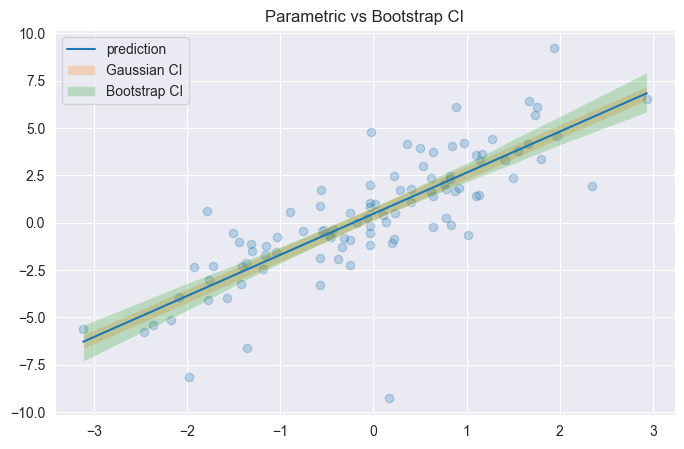

In [7]:
resid = y - y_hat
sigma_hat = np.std(resid, ddof=1)
n = len(y)
se_mean = sigma_hat/np.sqrt(n)
x_grid = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 120).reshape(-1,1)
pred_line = model.predict(x_grid)
gauss_lo = pred_line - 1.96*se_mean
gauss_hi = pred_line + 1.96*se_mean

def bootstrap_predictions(X, y, x_grid, n_boot=500, seed=111):
    rng = np.random.default_rng(seed)
    preds = []
    idx = np.arange(len(y))
    for _ in range(n_boot):
        b = rng.choice(idx, size=len(idx), replace=True)
        m = fit_fn(X[b].reshape(-1,1), y[b])
        preds.append(m.predict(x_grid))
    P = np.vstack(preds)
    return P.mean(axis=0), np.percentile(P, 2.5, axis=0), np.percentile(P, 97.5, axis=0)

m_boot, lo_boot, hi_boot = bootstrap_predictions(X_base, y, x_grid, n_boot=600)

plt.figure()
plt.scatter(X_base, y, alpha=0.25)
plt.plot(x_grid, pred_line, label='prediction')
plt.fill_between(x_grid.ravel(), gauss_lo, gauss_hi, alpha=0.25, label='Gaussian CI')
plt.fill_between(x_grid.ravel(), lo_boot, hi_boot, alpha=0.25, label='Bootstrap CI')
plt.legend(); plt.title('Parametric vs Bootstrap CI'); plt.show()

In [8]:
scenarios = {
    'mean_impute': mean_impute,
    'median_impute': median_impute,
    'drop_missing': lambda a: a[~np.isnan(a)] if np.isnan(a).any() else a
}

results = []
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xs, ys = X_raw[mask], y[mask]
        m = fit_fn(Xs.reshape(-1,1), ys)
        yh = m.predict(Xs.reshape(-1,1))
    else:
        Xs = fn(X_raw)
        m = fit_fn(Xs.reshape(-1,1), y)
        yh = m.predict(Xs.reshape(-1,1))
    results.append({'scenario': name, 'mae': mae(y[:len(yh)], yh), 'slope': m.coef_[0], 'intercept': m.intercept_})
sens = pd.DataFrame(results); sens

,scenario,mae,slope,intercept
0,mean_impute,1.287441,2.169729,0.465643
1,median_impute,1.284444,2.168392,0.449924
2,drop_missing,2.394552,2.169729,0.463851


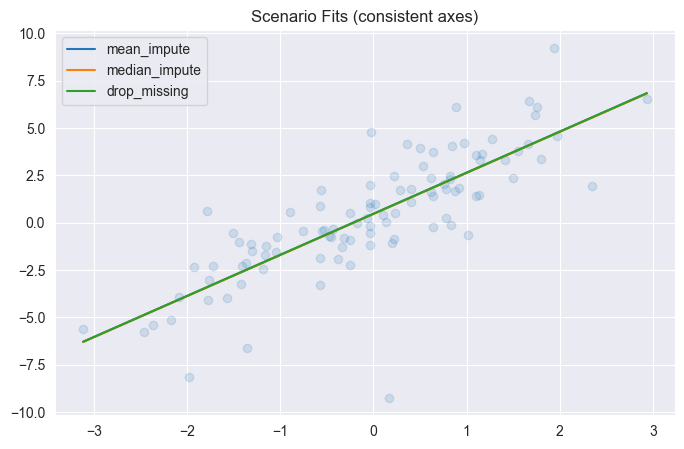

In [9]:
plt.figure()
xg = np.linspace(np.nanmin(X_base), np.nanmax(X_base), 150).reshape(-1,1)
for name, fn in scenarios.items():
    if name == 'drop_missing' and np.isnan(X_raw).any():
        mask = ~np.isnan(X_raw)
        Xi, yi = X_raw[mask], y[mask]
    else:
        Xi, yi = fn(X_raw), y
    m = fit_fn(Xi.reshape(-1,1), yi)
    plt.plot(xg, m.predict(xg), label=name)
plt.scatter(X_base, y, alpha=0.15)
plt.title('Scenario Fits (consistent axes)'); plt.legend(); plt.show()

In [10]:
model_base = fit_fn(X_base.reshape(-1,1), y)
df2 = df.copy()
df2['y_hat'] = model_base.predict(df2['x_imputed'].values.reshape(-1,1))
df2['resid'] = df2['y_target'] - df2['y_hat']
g = df2.groupby('segment')['resid'].agg(['mean','std','median','count'])
g

,mean,std,median,count
segment,,,,
A,0.103886,1.663141,-0.063589,56
B,0.560776,1.550081,0.609701,21
C,-0.764952,2.522898,-0.257077,23


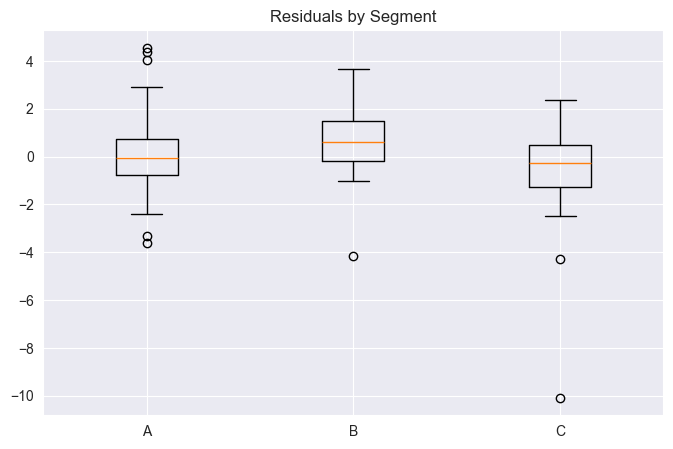

In [11]:
plt.figure()
grouped = df2.groupby('segment')['resid']
data = [s.values for _, s in grouped]
labels = list(grouped.groups.keys())

plt.boxplot(data, tick_labels=labels)
plt.title('Residuals by Segment')
plt.show()


In [12]:
bm = bootstrap_metric(y, df2['y_hat'].values, mae, n_boot=600)
bm

{'mean': 1.2780247486799765,
 'lo': 1.0537484762152678,
 'hi': 1.5459109661819437}

Key Assumptions:
The data are assumed to follow the same trend as it had before. The features used are assumed to be the sole indictor of the future outcome.
Sensitivity results & takeaways:
The drop missing method shows a higher MAE compared to the mean impute and median impute methods.
Subgroup Risks:
When segment into different groups, the residual of the Group C shows higher standard deviation.
If the distribution of the input data remains similar to the historical dataset, then the prediction is valid.
This model is highly sensitive to deviations like variance assumptions and the presence of structural breakpoints in the data.